In [17]:
import torch
import skshapes as sks
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [18]:
def create_ellipse(center=(0, 0), radius_x=1.0, radius_y=0.8, n_points=100):
    """
    Génère un objet PolyData représentant une ellipse (contour 2D).
    """
    # 1. Générer les Coordonnées (Les Points)
    theta = torch.linspace(0, 2 * np.pi, n_points + 1)[:-1] # On enlève le dernier pour ne pas doubler le 1er point
    
    # Équation paramétrique de l'ellipse
    x = center[0] + radius_x * torch.cos(theta)
    y = center[1] + radius_y * torch.sin(theta)
    
    # On empile pour avoir une forme (N, 2)
    points = torch.stack([x, y], dim=1).float()

    # 2. Générer la Connectivité (Les Lignes)
    # On relie le point i au point i+1
    indices = torch.arange(n_points)
    # Le dernier point doit se relier au premier (modulo) pour fermer la boucle
    edges = torch.stack([indices, (indices + 1) % n_points], dim=1)
    
    # 3. Création de l'objet scikit-shapes
    shape = sks.PolyData(points=points, edges=edges)
    
    return shape

def plot_polydata_2d(shape, ax, color, label, linestyle='-'):
    """
    Fonction utilitaire pour tracer un contour PolyData 2D avec matplotlib.
    """
    # 1. Récupérer les points du Tenseur PyTorch vers NumPy
    points_np = shape.points.numpy()
    
    # 2. Séparer X et Y
    x = points_np[:, 0]
    y = points_np[:, 1]
    
    # 3. ASTUCE : Fermer la boucle pour l'affichage
    # On rajoute le premier point à la fin de la liste
    x_plot = np.append(x, x[0])
    y_plot = np.append(y, y[0])
    
    # 4. Tracer
    ax.plot(x_plot, y_plot, color=color, label=label, linewidth=2, linestyle=linestyle)
    # Optionnel : afficher les points individuels
    # ax.scatter(x, y, color=color, s=10)

def merge_shapes(shape_a, shape_b):
    """Fusionne deux objets PolyData en un seul (disjoint)"""
    # 1. Concaténer les points
    points = torch.cat([shape_a.points, shape_b.points], dim=0)
    
    # 2. Ajuster les indices des arêtes de la forme B (décalage)
    offset = shape_a.n_points
    edges_b_shifted = shape_b.edges + offset
    
    # 3. Concaténer les arêtes
    edges = torch.cat([shape_a.edges, edges_b_shifted], dim=0)
    
    return sks.PolyData(points=points, edges=edges)

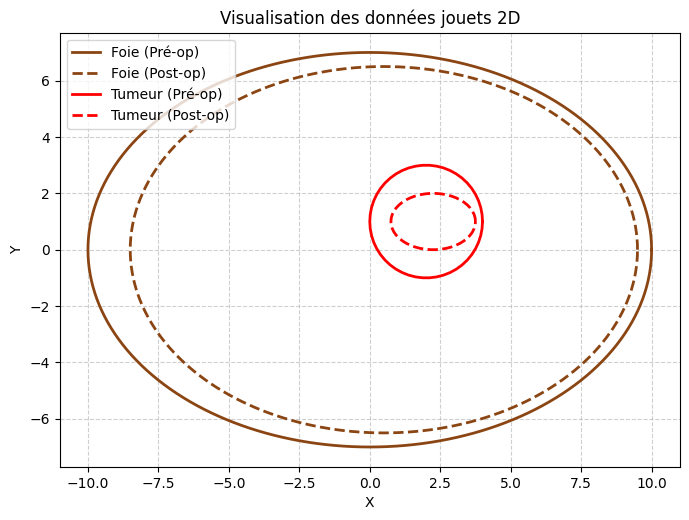

In [19]:
# --- Utilisation ---

# Créer le Foie (une grosse ellipse un peu déformée)
liver1 = create_ellipse(center=(0, 0), radius_x=10.0, radius_y=7.0, n_points=200)
liver2 = create_ellipse(center=(0.5, 0), radius_x=9.0, radius_y=6.5, n_points=200)

# Créer la Tumeur (un petit cercle à l'intérieur)
tumor1 = create_ellipse(center=(2, 1), radius_x=2.0, radius_y=2.0, n_points=50)
tumor2 = create_ellipse(center=(2.25, 1), radius_x=1.5, radius_y=1.0, n_points=50)

# Création de la figure
fig, ax = plt.subplots(figsize=(8, 6))

# Tracer le foie
plot_polydata_2d(liver1, ax, color='saddlebrown', label='Foie (Pré-op)')
plot_polydata_2d(liver2, ax, color='saddlebrown', label='Foie (Post-op)', linestyle='--')

# Tracer la tumeur
plot_polydata_2d(tumor1, ax, color='red', label='Tumeur (Pré-op)')
plot_polydata_2d(tumor2, ax, color='red', label='Tumeur (Post-op)', linestyle='--')


# Réglages importants
ax.set_aspect('equal')  # CRUCIAL : pour que les cercles ne ressemblent pas à des ellipses
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
plt.title("Visualisation des données jouets 2D")
plt.xlabel("X")
plt.ylabel("Y")

plt.show()

In [20]:
source = merge_shapes(liver1, tumor1)
target = merge_shapes(liver2, tumor2)